In [1]:
%load_ext autoreload

In [1]:
import nltk
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

import sys
sys.path.append('../../')

In [2]:
DATA_DIR = Path("../data/dev")
input_dir = DATA_DIR / "processed"
file_name = "medical_data.csv"

In [3]:
data =  pd.read_csv(input_dir / file_name)

In [4]:
data.head()

,case_id,patient_narrative,patient_question,clinician_question,note_excerpt,sentence_id,sentence_text,paragraph_id,start_char_index,length,relevance,document_id,document_source
0,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,0,brief hospital course,0,0,22,not-relevant,179164_41762,mimic-iii
1,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,1,during the ercp a pancreatic stent was require...,1,0,243,essential,179164_41762,mimic-iii
2,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,2,however due to the patients elevated inr no sp...,1,244,93,not-relevant,179164_41762,mimic-iii
3,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,3,frank pus was noted to be draining from the co...,1,338,151,not-relevant,179164_41762,mimic-iii
4,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,4,the vancomycin was discontinued,1,490,32,not-relevant,179164_41762,mimic-iii


# QA Model

**Conceptual Overview: What Are We Trying to Do?**

We are building a sentence-level relevance classifier to support medical question answering (QA) without using an LLM. Instead, we rely on traditional machine learning methods to mark relevant sentences in a clinical document.

**Problem Definition**

**Input:**
A medical question (e.g., from a patient or clinician).
A clinical document (context) (e.g., medical notes, discharge summaries).
Each document contains multiple sentences, some of which are relevant to the question.

**Goal:**
Identify and highlight sentences in the document that contain relevant information.
This helps in extracting meaningful answers from medical records.

**Expected Output:**
The same document, but with relevant sentences marked.


## Convert Context into Structured Data

- We split the clinical document into sentences.
- Each (question, sentence) pair is labeled as:
    - "essential" (1) → If the sentence contains relevant information.
    - "not-relevant" (0) → If the sentence is irrelevant.

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulschmitt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
data.columns

Index(['case_id', 'patient_narrative', 'patient_question',
       'clinician_question', 'note_excerpt', 'sentence_id', 'sentence_text',
       'paragraph_id', 'start_char_index', 'length', 'relevance',
       'document_id', 'document_source'],
      dtype='object')

In [7]:
data.head()

,case_id,patient_narrative,patient_question,clinician_question,note_excerpt,sentence_id,sentence_text,paragraph_id,start_char_index,length,relevance,document_id,document_source
0,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,0,brief hospital course,0,0,22,not-relevant,179164_41762,mimic-iii
1,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,1,during the ercp a pancreatic stent was require...,1,0,243,essential,179164_41762,mimic-iii
2,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,2,however due to the patients elevated inr no sp...,1,244,93,not-relevant,179164_41762,mimic-iii
3,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,3,frank pus was noted to be draining from the co...,1,338,151,not-relevant,179164_41762,mimic-iii
4,1,i had severe abdomen pain and was hospitalised...,my question is if the sludge was there does no...,why was ercp recommended to him over continuin...,brief hospital course during the ercp a pancre...,4,the vancomycin was discontinued,1,490,32,not-relevant,179164_41762,mimic-iii


In [8]:
from nltk import sent_tokenize

def create_sentence_pairs(df):
    data = []
    for _, row in df.iterrows():
        question = row["patient_question"]  # Use "clinician_question" if needed
        sentences = sent_tokenize(row["note_excerpt"])  # Split context into sentences

        for sentence in sentences:
            # Check if the sentence is marked as relevant
            label = 1 if sentence in row["sentence_text"] else 0
            data.append([question, sentence, label])

    return pd.DataFrame(data, columns=["question", "sentence", "label"])

In [9]:
observation = data.iloc[0]

In [10]:
observation

case_id                                                               1
patient_narrative     i had severe abdomen pain and was hospitalised...
patient_question      my question is if the sludge was there does no...
clinician_question    why was ercp recommended to him over continuin...
note_excerpt          brief hospital course during the ercp a pancre...
sentence_id                                                           0
sentence_text                                     brief hospital course
paragraph_id                                                          0
start_char_index                                                      0
length                                                               22
relevance                                                  not-relevant
document_id                                                179164_41762
document_source                                               mimic-iii
Name: 0, dtype: object

In [11]:
observation.patient_question

'my question is if the sludge was there does not the medication help in flushing it out whether ercp was the only cure'

In [12]:
observation.sentence_text

'brief hospital course'

In [13]:
observation.relevance

'not-relevant'

In [14]:
data["relevance"].value_counts()

relevance
not-relevant     239
essential        138
supplementary     51
Name: count, dtype: int64

We first encode the relevance labels in binary form to keep it simple for now

In [15]:
data["relevance"] = data["relevance"].map({
    "not-relevant": 0,
    "essential": 1,
    "supplementary": 1  # Treat supplementary as relevant
})

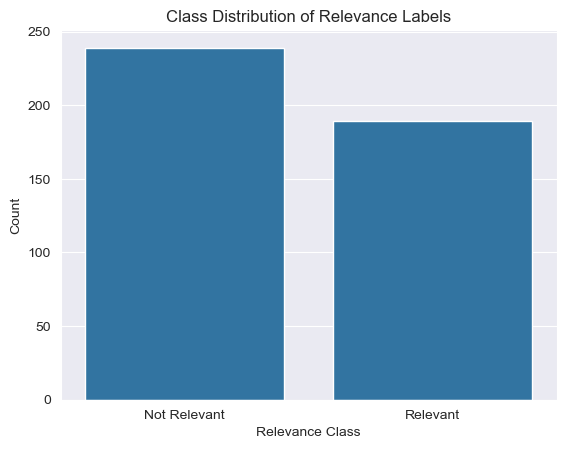

In [16]:
# Count class occurrences
class_counts = data["relevance"].value_counts()

# Example of plotting with seaborn
sns.barplot(x=[0, 1], y=class_counts)  # Replace with actual data
plt.xticks(ticks=[0, 1], labels=["Not Relevant", "Relevant"])  # Update labels
plt.xlabel("Relevance Class")
plt.ylabel("Count")
plt.title("Class Distribution of Relevance Labels")

plt.show()

# Prepare Data for Training

Split the dataset

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data[["patient_question", "sentence_text"]], data["relevance"], test_size=0.2, random_state=1050
)

**Convert Text into Features:**

We use pretrained BERT-based models to generate dense vector embeddings for:
- The question (question column).
- The sentence (sentence_text column).

Then, we concatenate the embeddings and feed them into a classifier.


In [19]:
from sentence_transformers import SentenceTransformer
import numpy as np

Generate Sentence Embeddings with BERT

In [24]:
# Load a pretrained SBERT model (optimized for sentence embeddings)
bert_model = SentenceTransformer("all-MiniLM-L6-v2")  # Small & fast, but effective

# Function to generate embeddings for (question, sentence) pairs
def encode_text_pairs(df):
    questions = df["patient_question"].tolist()
    sentences = df["sentence_text"].tolist()

    # Encode question and sentence separately
    question_embeddings = bert_model.encode(questions, convert_to_numpy=True)
    sentence_embeddings = bert_model.encode(sentences, convert_to_numpy=True)

    # Concatenate both embeddings (shape: [num_samples, embedding_size * 2])
    return np.hstack((question_embeddings, sentence_embeddings))

# Convert text to BERT embeddings
X_train_bert = encode_text_pairs(X_train)
X_test_bert = encode_text_pairs(X_test)

# Verify shape
print("BERT embeddings shape:", X_train_bert.shape)

BERT embeddings shape: (342, 768)


Train a Classifier Using BERT Embeddings

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression
clf_bert = LogisticRegression(max_iter=500)
clf_bert.fit(X_train_bert, y_train)

# Predict on test data
y_pred_bert = clf_bert.predict(X_test_bert)

# Evaluate performance
print("Accuracy with BERT embeddings:", accuracy_score(y_test, y_pred_bert))
print(classification_report(y_test, y_pred_bert))

Accuracy with BERT embeddings: 0.6046511627906976
              precision    recall  f1-score   support

           0       0.56      0.80      0.66        41
           1       0.70      0.42      0.53        45

    accuracy                           0.60        86
   macro avg       0.63      0.61      0.59        86
weighted avg       0.63      0.60      0.59        86



In [26]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

relevance
0    0.578947
1    0.421053
Name: proportion, dtype: float64
relevance
1    0.523256
0    0.476744
Name: proportion, dtype: float64


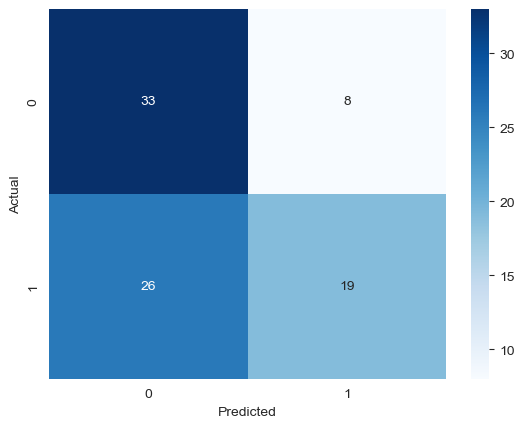

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()